In [6]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [63]:
M = 2                # the population has two age groups
N = 5e4              # and this is the total population

# parameters for generating synthetic trajectory 
beta  = 0.02         # infection rate
gIa   = 1./7         # recovery rate of asymptomatic infectives
gIs   = 1./7         # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 1          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], 
              [3., 12.]]) 
# C_ij = number of people group from group i that an individual from group j meets per day 

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])  # and also symptomatic infectives
R0  = np.array([0, 0])    # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
true_parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SIR_sto_traj.npy', data_array)

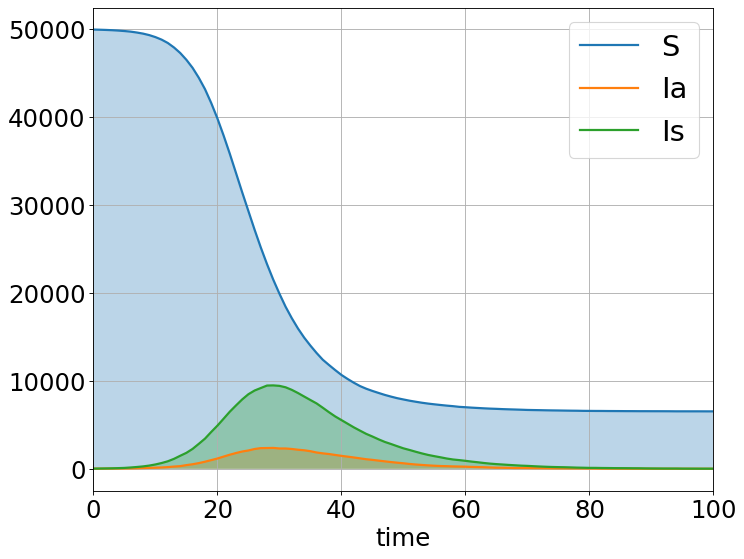

In [64]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = data['t']

plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=2)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ia', lw=2)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Is', lw=2)

plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

In [65]:
# load the data and rescale to intensive variables 
Tf_inference = 20 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1

x = np.load('SIR_sto_traj.npy').astype('float')
x = (x/N)[:Nf_inference]
steps = 101 # number of integration steps taken
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

In [66]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix, tangent=True)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-923.7920902063948
0.004335880279541016


In [67]:
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix, tangent=False)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-889.4806710836507
0.13982391357421875


In [75]:
# Define the prior (Gamma prior around guess of parameter with defined std. deviation)
alpha_g = 0.24
beta_g = 0.04
gIa_g = 0.1
gIs_g = 0.2

keys = ['alpha', 'beta', 'gIa', 'gIs']

# initial guess 
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])  

# error bars on the initial guess 
alpha_std = 0.2
beta_std = 0.1
gIa_std = 0.2
gIs_std = 0.2
stds = np.array([alpha_std, beta_std , gIa_std, gIs_std])

eps = 1e-4
# bounds on the parameters 
bounds = np.array([(eps, 0.8), (eps, 0.2), (eps, 0.6), (eps, 0.6)]) 

# Stopping criterion for minimisation (realtive change in function value)
ftol = 1e-7
start_time = time.time() 
params = estimator.infer_parameters(keys, guess, stds, bounds, x, Tf_inference, Nf_inference, 
                                    contactMatrix, 
                                    tangent=True,
                                    global_max_iter=10,
                                    enable_global=True, 
                                    local_max_iter=200, 
                                    global_ftol_factor=1e3, 
                                    ftol=ftol, 
                                    verbose=True)
end_time = time.time()

print(params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 4 (seed=3177848602, Wed May 20 17:29:40 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -2.150304481970914e+02 1.0e+00 9.94e-01  7e-02  2e-01 0:00.1
    2     32 3.957987243116572e+02 1.7e+00 9.65e-01  6e-02  2e-01 0:00.1
    3     48 1.523479430651059e+03 1.9e+00 9.92e-01  7e-02  2e-01 0:00.1
Optimal value (global minimisation):  -464.38433805832983
Starting local minimisation...
Optimal value (local minimisation):  -934.0604602701088
[0.14736383 0.02009    0.06273248 0.16271054]
0.8533139228820801


In [72]:
full_params = estimator.fill_params_dict(keys, params)
estimator.set_params(full_params)
estimator.obtain_minus_log_p(full_params, x, Tf_inference, Nf_inference, contactMatrix, tangent=True)
# this is logp without prior 

-927.4879354073554

In [74]:
# Define the prior (Gamma prior around guess of parameter with defined std. deviation)
alpha_g = 0.24
beta_g = 0.04
gIa_g = 0.1
gIs_g = 0.2

keys = ['alpha', 'beta', 'gIa', 'gIs']

# initial guess 
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])  

# error bars on the initial guess 
alpha_std = 0.2
beta_std = 0.1
gIa_std = 0.2
gIs_std = 0.2
stds = np.array([alpha_std, beta_std , gIa_std, gIs_std])

eps = 1e-4
# bounds on the parameters 
bounds = np.array([(eps, 0.8), (eps, 0.2), (eps, 0.6), (eps, 0.6)]) 

# Stopping criterion for minimisation (realtive change in function value)
ftol = 1e-6
start_time = time.time() 
params = estimator.infer_parameters(keys, guess, stds, bounds, x, Tf_inference, Nf_inference, 
                                    contactMatrix, 
                                    tangent=False,
                                    global_max_iter=10,
                                    enable_global=True, 
                                    local_max_iter=200, 
                                    global_ftol_factor=1e3, 
                                    ftol=ftol, 
                                    verbose=True)
end_time = time.time()

print(params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 4 (seed=2988126970, Wed May 20 17:28:42 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -6.151808669200133e+02 1.0e+00 9.82e-01  8e-02  2e-01 0:02.4
    2     32 -1.604211956367910e+02 1.6e+00 1.21e+00  1e-01  3e-01 0:03.9
    3     48 2.053363268483397e+03 1.7e+00 1.21e+00  1e-01  3e-01 0:05.6
    6     96 -1.215844589688428e+02 2.5e+00 1.20e+00  9e-02  3e-01 0:10.6
    9    144 2.000300174817479e+03 2.7e+00 1.09e+00  7e-02  3e-01 0:15.6
Optimal value (global minimisation):  -615.1808669200133
Starting local minimisation...
Optimal value (local minimisation):  -896.7526618461351
[0.17689111 0.02003595 0.11632765 0.15030921]
34.18470096588135


In [77]:
full_params = estimator.fill_params_dict(keys, params)
estimator.set_params(full_params)
estimator.obtain_minus_log_p(full_params, x, Tf_inference, Nf_inference, contactMatrix, tangent=False)
# this is logp without prior 

-888.1856657254517